# Advanced Deep Learning AS24
## Exploration of Graphs in Python / PyTorch for molecular Deep Learning

- Some exploration how to create Graphs from SMILES and how to convert them into suitable format for Graph Neural Networks

---

In [103]:
# import necessary packages
import pandas as pd
import torch
import matplotlib.pyplot as plt
import networkx as nx

# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, AddHs
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (500, 500)   # Change image size
IPythonConsole.ipython_useSVG = True  # Change output to SVG

# DGL or DGL life respectively to create graphs
from dgllife.utils.featurizers import CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import mol_to_bigraph

# pytorch geometric
from torch_geometric.data import Data

---
## Read in and Process Data

In [104]:
# read in logP data
logP_df = pd.read_csv('../data/logP.csv')

# display df
logP_df.head()

,smiles,logP
0,BrC(Br)(Br)Br,3.42
1,BrC1C2CC3C(C2)C13,3.11
2,BrC1CC2CCC1C2,3.54
3,BrC1CCCCC1,3.20
4,BrC=C(Br)Br,3.20


In [105]:
# get stats
logP_df.describe()

,logP
count,13688.000000
mean,2.126264
std,1.867572
min,-4.650000
25%,0.890000
50%,2.030000
75%,3.250000
max,9.960000


In [106]:
# check for NAN values
logP_df.isnull().sum()  # no missing values

smiles    0
logP      0
dtype: int64

,smiles,logP,molecule
0,BrC(Br)(Br)Br,3.42,
1,BrC1C2CC3C(C2)C13,3.11,
2,BrC1CC2CCC1C2,3.54,
3,BrC1CCCCC1,3.20,
4,BrC=C(Br)Br,3.20,

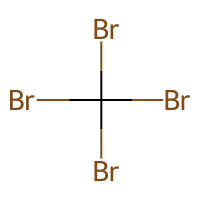
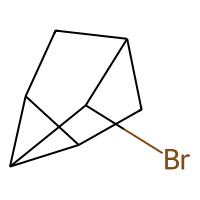
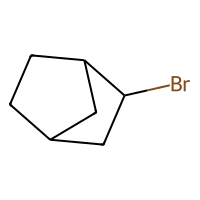
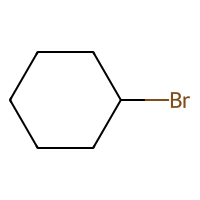
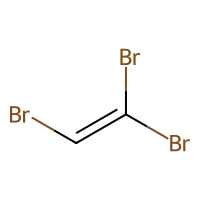

In [107]:
# some rdkit operations on a pandas df
PandasTools.AddMoleculeColumnToFrame(logP_df, smilesCol='smiles', molCol='molecule') # no molecules are displayed
PandasTools.RenderImagesInAllDataFrames(images=True) # doesn't fix the issue

logP_df.head()

---

## Process molecule into Graphs for DL

In [108]:
smiles_list = logP_df['smiles'].tolist()    # extract smiles
logP_list = logP_df['logP'].tolist()    # extract logP values
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]   # convert smiles into mol objects (RDKit)

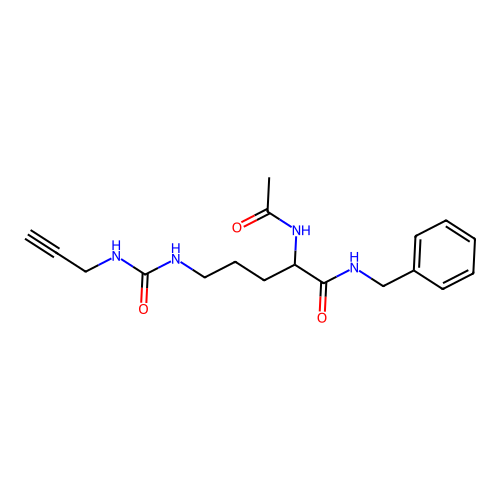

In [109]:
# extract mol-object to demonstrate the workflow
index= 100 # comments below refer to molecule with index 20!

dummy_mol = mol_list[index]
dummy_smiles = smiles_list[index]

dummy_mol

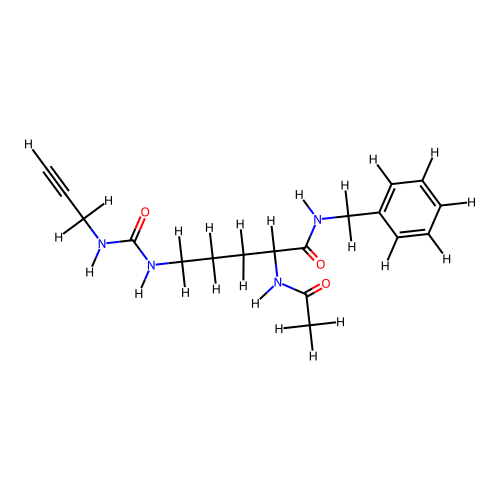

In [110]:
# explicitly add protons to mol-object (we may want to do this in order to get them as nodes in our graphs)
dummy_mol_protons = AddHs(dummy_mol)

dummy_mol_protons

check the dgllife docs to see what features are extracted for the nodes and edges:

[mol_to_bigraph](https://lifesci.dgl.ai/generated/dgllife.utils.mol_to_bigraph.html#dgllife.utils.mol_to_bigraph)

[CanonicalAtomFeaturizer](https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalAtomFeaturizer.html)

[CanoncalBondFeaturizer](https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalBondFeaturizer.html)


In [111]:
# get DGL-Graph
atom_featurizer = CanonicalAtomFeaturizer()
bond_featurizer = CanonicalBondFeaturizer()
dgl_graph = mol_to_bigraph(dummy_mol, node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer)

In [112]:
#
#   "explore" dgl graph
#

# dgl graph type
print('Type of created DGL Graph:\n')
print(type(dgl_graph))
print('='*100)

# dgl graph info
print('Displaying DGL Graph:\n') # We have 11 atoms --> 11 nodes, we have 12 bounds in total between all the atoms (information about bonds, e.g. double bond are edge features), since the bounds are bidirectional we end up by 12*2=24 edges.
print(dgl_graph)
print('='*100)

# get node data
#print('Display Node Tensors:\n')
#print(dgl_graph.ndata['h'])    # this returns the tensors
print('Get Shape and Type of Node Tensors:\n')
print(dgl_graph.ndata['h'].shape) # 11 Tensors with each having 74 dimensions
print(type(dgl_graph.ndata['h']))
print('='*100)

# get edge data
print('Display Edge Tensors:\n')
#print(dgl_graph.edata['e'])

print('Get Shape and Type of Edge Tensors:\n')
print(dgl_graph.edata['e'].shape) # 24 Tensors each having 12 dimensions
print(type(dgl_graph.edata['e']))
print('='*100)

# get number of nodes and edges directly
print(f'Number of nodes in Graph: {dgl_graph.number_of_nodes()}')
print(f'Number of edges in Graph: {dgl_graph.number_of_edges()}')


Type of created DGL Graph:

<class 'dgl.heterograph.DGLGraph'>
Displaying DGL Graph:

Graph(num_nodes=25, num_edges=50,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(12,), dtype=torch.float32)})
Get Shape and Type of Node Tensors:

torch.Size([25, 74])
<class 'torch.Tensor'>
Display Edge Tensors:

Get Shape and Type of Edge Tensors:

torch.Size([50, 12])
<class 'torch.Tensor'>
Number of nodes in Graph: 25
Number of edges in Graph: 50


---
## Convert to PyTorch Geometric Data Object

- Note: This should be our format as Input for our GNN's using PyTorch Geometric

In [113]:
# Extract node features from DGL graph
node_features = dgl_graph.ndata['h']  # Node features: Shape [num_nodes, num_node_features]

# Extract edge features from DGL graph
edge_features = dgl_graph.edata['e']  # Edge features: Shape [num_edges, num_edge_features]

# Extract edge index (source and destination nodes of edges)
src, dst = dgl_graph.edges()  # Returns two tensors: source nodes and destination nodes
edge_index = torch.stack([src, dst], dim=0)  # Shape [2, num_edges]

# Create PyTorch Geometric Data object
pytorch_geo_graph = Data(
    x=node_features,             # Node features
    edge_index=edge_index,       # Edge indices
    edge_attr=edge_features      # Edge features
)

In [114]:
print(type(pytorch_geo_graph))
print(pytorch_geo_graph) # build GNN with pytorch geometric and check if it runs as expected.

<class 'torch_geometric.data.data.Data'>
Data(x=[25, 74], edge_index=[2, 50], edge_attr=[50, 12])


---
## Convert to NetworkX Graphs

- Try out some visualizations of Graphs using Networkx graphs

In [121]:
# Note: These functions were generated with the assistance of OpenAI's ChatGPT4o.
def mol_to_networkx(mol):
    """
    Convert an RDKit Mol object to a NetworkX graph with atom and bond attributes,
    including 2D coordinates for visualization.

    Parameters:
    - mol: RDKit Mol object

    Returns:
    - nx_graph: A NetworkX graph with 2D coordinates stored in the "pos" attribute of nodes.
    """
    # Generate 2D coordinates
    AllChem.Compute2DCoords(mol)

    # Create a NetworkX graph
    nx_graph = nx.Graph()

    # Extract the 2D positions from the RDKit conformer
    conf = mol.GetConformer()
    positions = {atom.GetIdx(): (conf.GetAtomPosition(atom.GetIdx()).x,
                                 conf.GetAtomPosition(atom.GetIdx()).y)
                 for atom in mol.GetAtoms()}

    # Add nodes with atom attributes and positions
    for atom in mol.GetAtoms():
        nx_graph.add_node(
            atom.GetIdx(),
            element=atom.GetSymbol(),  # Atom type (e.g., 'C', 'O', 'H')
            atomic_num=atom.GetAtomicNum(),  # Atomic number
            is_aromatic=atom.GetIsAromatic(),  # Aromaticity
            formal_charge=atom.GetFormalCharge(),  # Formal charge
            pos=positions[atom.GetIdx()]  # 2D position
        )

    # Add edges with bond attributes
    for bond in mol.GetBonds():
        nx_graph.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=str(bond.GetBondType()),  # Bond type (e.g., 'SINGLE', 'DOUBLE')
            is_aromatic=bond.GetIsAromatic()  # Aromaticity of bond
        )

    return nx_graph

def plot_molecule_graph(graph, atom_colors=None, pos=None):
    """
    Plot a molecular graph with colored nodes and proper geometry.

    Parameters:
    - graph: networkx.Graph, the molecular graph.
             Nodes should have an "element" attribute (e.g., "C", "O", etc.).
    - atom_colors: dict, optional, a lookup table mapping atomic symbols to colors.
                   If None, a default table for common organic elements is used.
    - pos: dict, optional, positions of nodes (e.g., from 3D coordinates).
           If None, positions will be extracted from node attributes or computed with spring_layout.
    """
    # Default atom colors for common organic elements
    default_atom_colors = {
        "H": "white",  # Hydrogen
        "C": "black",  # Carbon
        "O": "red",    # Oxygen
        "N": "blue",   # Nitrogen
        "S": "yellow", # Sulfur
        "P": "orange", # Phosphorus
        "F": "green",  # Fluorine
        "Cl": "lime",  # Chlorine
        "Br": "brown", # Bromine
        "I": "purple"  # Iodine
    }

    # Use the default atom colors if none are provided
    if atom_colors is None:
        atom_colors = default_atom_colors

    # Ensure nodes have the "element" attribute
    if not all("element" in data for _, data in graph.nodes(data=True)):
        raise ValueError("All nodes must have an 'element' attribute for coloring.")

    # Check for positions in node attributes
    if pos is None:
        if all("pos" in data for _, data in graph.nodes(data=True)):
            # Extract positions from node attributes
            pos = {node: data["pos"][:2] for node, data in graph.nodes(data=True)}
        else:
            # Fallback to spring_layout if no positions are available
            pos = nx.spring_layout(graph, seed=42)

    # Extract colors for nodes based on atom type
    node_colors = [atom_colors.get(graph.nodes[node]["element"], "gray") for node in graph.nodes()]

    # Plot the molecular graph
    plt.figure(figsize=(8, 8))
    nx.draw(
        graph,
        pos,
        node_color=node_colors,
        with_labels=True,
        labels={node: graph.nodes[node]["element"] for node in graph.nodes()},
        edge_color="black",
        node_size=600,
        font_size=10,
        font_color="white"
    )
    plt.title("Molecular Graph")
    plt.show()

In [122]:
# create nx graph
nx_graph = mol_to_networkx(dummy_mol)

print(nx_graph)
print(type(nx_graph))

Graph with 25 nodes and 25 edges
<class 'networkx.classes.graph.Graph'>


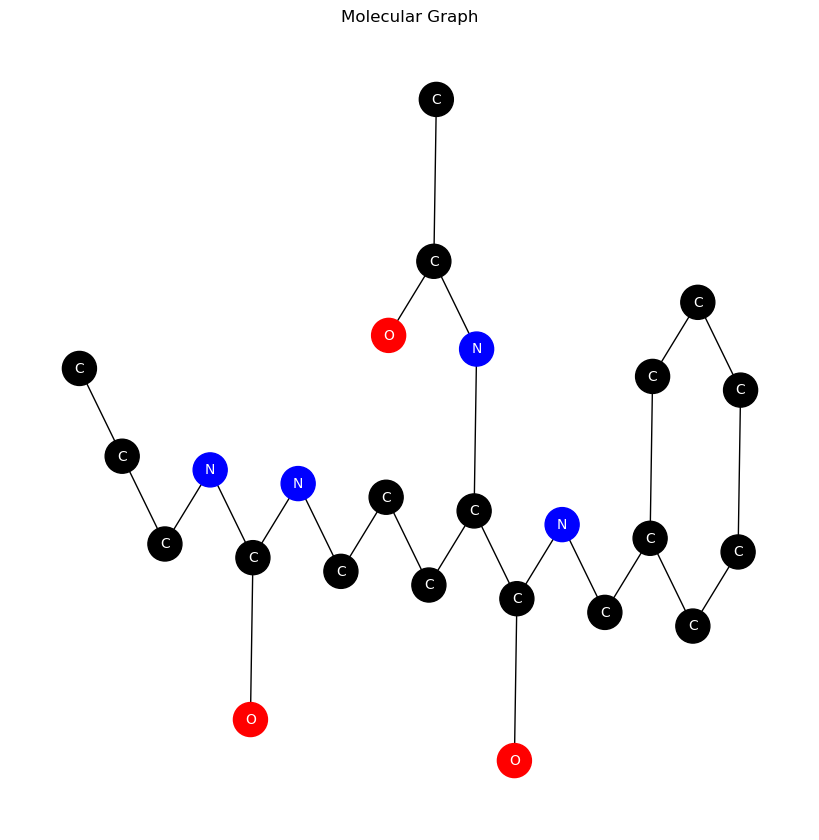

In [123]:
# plot the graph
plot_molecule_graph(nx_graph)